In [1]:
pip install pyproj

In [2]:
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
!pip uninstall cython -y
!pip install cython
!pip uninstall cartopy -y
!pip install cartopy

Found existing installation: Cython 3.0.5
Uninstalling Cython-3.0.5:
  Successfully uninstalled Cython-3.0.5
  Using cached Cython-3.0.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
Found existing installation: Cartopy 0.22.0
Uninstalling Cartopy-0.22.0:
  Successfully uninstalled Cartopy-0.22.0
  Using cached Cartopy-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)


In [4]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.2
Uninstalling shapely-2.0.2:
  Successfully uninstalled shapely-2.0.2
  Using cached shapely-2.0.2-cp310-cp310-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [5]:
import pandas as pd
import pyproj
import math
import matplotlib.pyplot as plt
import seaborn as sb
import urllib.request

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np

import cartopy
import cartopy.crs as ccrs                   # for projections
import cartopy.feature as cfeature           # for features
import cartopy.io.shapereader as shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade
import geopandas as gpd
import random
from shapely.geometry import Point, Polygon
import time

In [6]:
ruta = 'https://raw.githubusercontent.com/fmoreno4/datasets/main/eventos_dengue_2020.csv'
df = pd.read_csv(ruta)
df

ID     fec_not  semana   año  edad_  uni_med_ sexo_  cod_pais_o  \
0        1  17/01/2020       1  2020     25         1     F         170   
1        2  10/01/2020       1  2020     24         1     M         170   
2        3  12/01/2020       1  2020     58         1     M         170   
3        4  12/01/2020       1  2020     29         1     F         170   
4        5  10/01/2020       1  2020     56         1     F         170   
...    ...         ...     ...   ...    ...       ...   ...         ...   
1257  1258   7/03/2020       9  2020     36         1     F         170   
1258  1259  13/03/2020       9  2020     42         1     M         170   
1259  1260   8/03/2020       9  2020      2         1     M         170   
1260  1261  11/03/2020       9  2020     12         1     F         170   
1261  1262   9/03/2020       9  2020     14         1     M         170   

      cod_dpto_o  cod_mun_o  ...  hipotension  hepatomegalia  \
0             68        276  ...            2              2   
1             68        276  ...            2              2   
2             68        276  ...            2              2   
3             68        276  ...            2              2   
4             68        276  ...            2              2   
...          ...        ...  ...          ...            ...   
1257          68        276  ...            2              2   
1258          68        276  ...            2              2   
1259          68        276  ...            2              2   
1260          68        276  ...            2              2   
1261          68        276  ...            2              2   

     hemorragia_mucosa hipotermia  caida_plaquetas  acum_liquido  \
0                    2          2                2             2   
1                    2          2                2             2   
2                    2          2                2             2   
3                    2          2                2             2   
4                    2          2                1             2   
...                ...        ...              ...           ...   
1257                 1          2                2             2   
1258                 2          2                1             2   
1259                 2          2                2             2   
1260                 2          2                2             2   
1261                 2          2                2             2   

      aum_hematocrito                 conducta   latitud   longitud  
0                   2           1. Ambulatorio  7.076011 -73.102501  
1                   2           1. Ambulatorio  7.079495 -73.105400  
2                   2           1. Ambulatorio  7.090290 -73.091003  
3                   2           1. Ambulatorio  7.067435 -73.090958  
4                   2  2. Hospitalizacion piso  7.066905 -73.104980  
...               ...                      ...       ...        ...  
1257                2           1. Ambulatorio  7.072610 -73.099487  
1258                1  2. Hospitalizacion piso  7.065252 -73.103607  
1259                2           1. Ambulatorio  7.091391 -73.103264  
1260                2           1. Ambulatorio  7.061083 -73.097000  
1261                2  2. Hospitalizacion piso  7.062521 -73.080444  

[1262 rows x 51 columns]

In [7]:
#Se formatean los datos de fecha
from datetime import datetime

df['fec_not2'] = pd.to_datetime(df['fec_not'], format="%d/%m/%Y")
df['fecha_contagio2'] = pd.to_datetime(df['fecha_contagio'], format="%d/%m/%Y")
df['inicio_sintomas2'] = pd.to_datetime(df['inicio_sintomas'], format="%d/%m/%Y")
df['fec_hos_2'] = pd.to_datetime(df['fec_hos_'], format="%d/%m/%Y")
df

ID     fec_not  semana   año  edad_  uni_med_ sexo_  cod_pais_o  \
0        1  17/01/2020       1  2020     25         1     F         170   
1        2  10/01/2020       1  2020     24         1     M         170   
2        3  12/01/2020       1  2020     58         1     M         170   
3        4  12/01/2020       1  2020     29         1     F         170   
4        5  10/01/2020       1  2020     56         1     F         170   
...    ...         ...     ...   ...    ...       ...   ...         ...   
1257  1258   7/03/2020       9  2020     36         1     F         170   
1258  1259  13/03/2020       9  2020     42         1     M         170   
1259  1260   8/03/2020       9  2020      2         1     M         170   
1260  1261  11/03/2020       9  2020     12         1     F         170   
1261  1262   9/03/2020       9  2020     14         1     M         170   

      cod_dpto_o  cod_mun_o  ...  caida_plaquetas  acum_liquido  \
0             68        276  ...                2             2   
1             68        276  ...                2             2   
2             68        276  ...                2             2   
3             68        276  ...                2             2   
4             68        276  ...                1             2   
...          ...        ...  ...              ...           ...   
1257          68        276  ...                2             2   
1258          68        276  ...                1             2   
1259          68        276  ...                2             2   
1260          68        276  ...                2             2   
1261          68        276  ...                2             2   

     aum_hematocrito                 conducta   latitud   longitud   fec_not2  \
0                  2           1. Ambulatorio  7.076011 -73.102501 2020-01-17   
1                  2           1. Ambulatorio  7.079495 -73.105400 2020-01-10   
2                  2           1. Ambulatorio  7.090290 -73.091003 2020-01-12   
3                  2           1. Ambulatorio  7.067435 -73.090958 2020-01-12   
4                  2  2. Hospitalizacion piso  7.066905 -73.104980 2020-01-10   
...              ...                      ...       ...        ...        ...   
1257               2           1. Ambulatorio  7.072610 -73.099487 2020-03-07   
1258               1  2. Hospitalizacion piso  7.065252 -73.103607 2020-03-13   
1259               2           1. Ambulatorio  7.091391 -73.103264 2020-03-08   
1260               2           1. Ambulatorio  7.061083 -73.097000 2020-03-11   
1261               2  2. Hospitalizacion piso  7.062521 -73.080444 2020-03-09   

      fecha_contagio2  inicio_sintomas2  fec_hos_2  
0          2020-01-17        2020-01-10        NaT  
1          2020-01-10        2020-01-07        NaT  
2          2020-01-12        2020-01-08        NaT  
3          2020-01-10        2020-01-06        NaT  
4          2020-01-10        2020-01-07 2020-01-10  
...               ...               ...        ...  
1257       2020-03-06        2020-03-03        NaT  
1258       2020-03-13        2020-03-06 2020-03-13  
1259       2020-03-08        2020-03-04        NaT  
1260       2020-03-11        2020-03-05        NaT  
1261       2020-03-06        2020-03-02 2020-03-06  

[1262 rows x 55 columns]

# Limpieza de datos

In [8]:
dfCoord=df[['longitud', 'latitud']].copy()
dfCoord

longitud   latitud
0    -73.102501  7.076011
1    -73.105400  7.079495
2    -73.091003  7.090290
3    -73.090958  7.067435
4    -73.104980  7.066905
...         ...       ...
1257 -73.099487  7.072610
1258 -73.103607  7.065252
1259 -73.103264  7.091391
1260 -73.097000  7.061083
1261 -73.080444  7.062521

[1262 rows x 2 columns]

In [9]:
#Ver si hay nulos
dfCoord.isnull().sum()

longitud    0
latitud     0
dtype: int64

In [10]:
#Ver si hay nan
dfCoord.isna().sum()

longitud    0
latitud     0
dtype: int64

In [11]:
# Puntos Floridablanca
lower_lon = -73.1215
upper_lon = -73.0732
lower_lat = 7.054
upper_lat = 7.1005

In [12]:
#Filtrar valores que salen del mapa
dfCoord=dfCoord[(dfCoord['longitud']>=lower_lon)&(dfCoord['longitud']<=upper_lon)&(dfCoord['latitud']>=lower_lat)&(dfCoord['latitud']<=upper_lat)]
dfCoord

longitud   latitud
0    -73.102501  7.076011
1    -73.105400  7.079495
2    -73.091003  7.090290
3    -73.090958  7.067435
4    -73.104980  7.066905
...         ...       ...
1257 -73.099487  7.072610
1258 -73.103607  7.065252
1259 -73.103264  7.091391
1260 -73.097000  7.061083
1261 -73.080444  7.062521

[1262 rows x 2 columns]

In [13]:
#Creación de la proyección
P = pyproj.Proj(proj='utm', zone=18, ellps='WGS84', preserve_units=True)

In [14]:
#Se convertirán las coordenadas geográficas a UTM
dfCoord['x'], dfCoord['y'] = P(dfCoord['longitud'], dfCoord['latitud'])
dfCoord

longitud   latitud              x              y
0    -73.102501  7.076011  709584.027559  782579.281866
1    -73.105400  7.079495  709262.121378  782963.354103
2    -73.091003  7.090290  710847.924654  784163.825097
3    -73.090958  7.067435  710863.366771  781635.895608
4    -73.104980  7.066905  709314.159319  781570.969374
...         ...       ...            ...            ...
1257 -73.099487  7.072610  709918.546763  782204.438977
1258 -73.103607  7.065252  709466.644754  781388.734012
1259 -73.103264  7.091391  709492.782783  784279.996264
1260 -73.097000  7.061083  710198.574916  780930.648555
1261 -73.080444  7.062521  712027.277417  781097.169210

[1262 rows x 4 columns]

In [15]:
#Se carga la cartografía de Floridablanca
url = 'https://raw.githubusercontent.com/fmoreno4/cd-files/main/'

file_list = ["68276_urbano.cpg", "68276_urbano.dbf", "68276_urbano.prj", "68276_urbano.shp", "68276_urbano.shx"]

for file in file_list:
    urllib.request.urlretrieve(url+file, file)

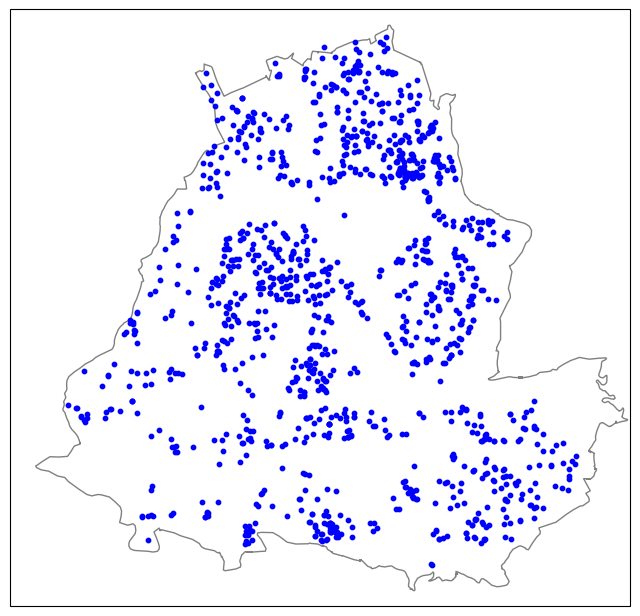

In [16]:
subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=subplot_kw)

ax.set_extent([lower_lon, upper_lon, lower_lat, upper_lat])

reader = shapereader.Reader('68276_urbano.shp')

for poli in reader.geometries():
    ax.add_geometries([poli], ccrs.PlateCarree(), facecolor='white', edgecolor='gray')

ax.scatter(dfCoord['longitud'], dfCoord['latitud'], zorder=10, c='b', s=10)

plt.show()

# Matriz de conteos

In [17]:
def divideDistance(a,b,resolucion):
  c=(a-b)/resolucion
  return c

In [18]:
def countingMatrix(resolucion):
  #Puntos maximos y minimos
  xmax=dfCoord['x'].max()
  xmin=dfCoord['x'].min()
  ymax=dfCoord['y'].max()
  ymin=dfCoord['y'].min()

  #obtener filas y columnas
  columnas=math.ceil(divideDistance(xmax,xmin,resolucion))
  filas=math.ceil(divideDistance(ymax,ymin,resolucion))
  print(columnas, filas)

  #Llenar matriz de ceros
  matriz=[]
  matriz = [[0 for _ in range(columnas)] for _ in range(filas)]

  #Recorrer dataframe
  for indice, fila in dfCoord.iterrows():
    columna=math.floor(divideDistance(fila['x'],xmin,resolucion))
    fila=math.floor(divideDistance(fila['y'],ymin,resolucion))
    matriz[fila][columna] = matriz[fila][columna]+1
  return matriz


In [19]:
#definir resolucion
resolucion=10

In [20]:
#Crear matriz
matriz=countingMatrix(resolucion)
matriz=np.flipud(matriz)
for fila in matriz:
    print(fila)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

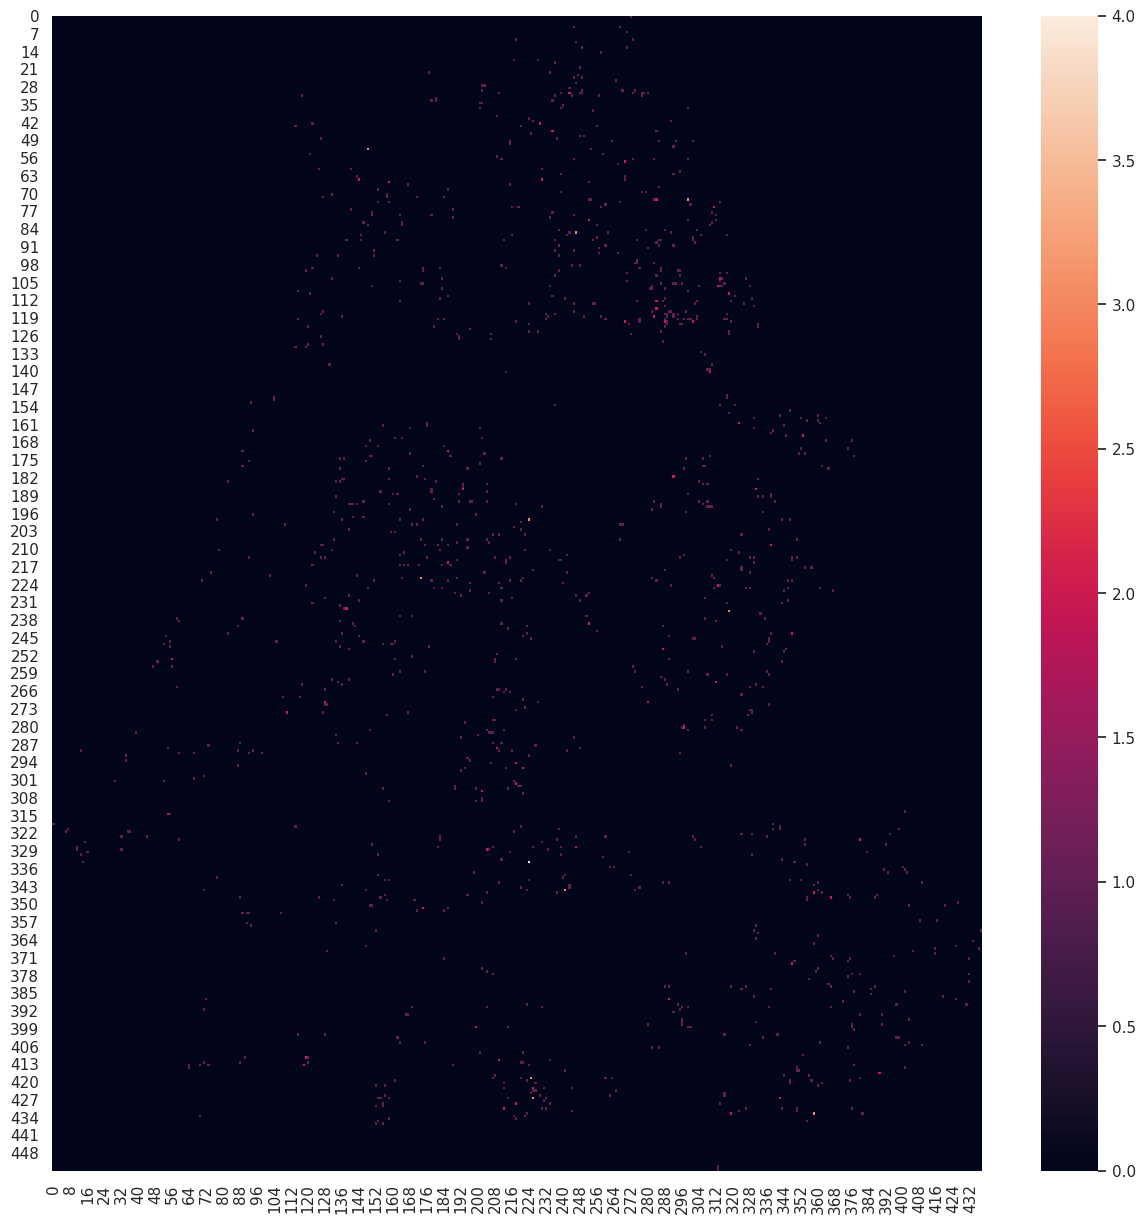

In [21]:
#Visualizacion de datos
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,15)})
p=sns.heatmap(matriz)

# Matriz de densidades

In [22]:
#Obtener filas y columnas de la matriz
rows=len(matriz)
cols=len(matriz[0])
print(cols, rows)

438 455


In [23]:
#Calcular distancia con teorema de Pitágoras
def pitDist(x1,y1,x2,y2):
  d=math.sqrt(((x2-x1)**2)+((y2-y1)**2))
  return d

In [24]:
#Crear las funciones de kernel

def uniforme(d,r):
  k=1
  return k

def triangular(d,r):
  k=1-(d/r)
  return k

def gaussiana(d,r):
  k=(math.e)**(-((d**2)/(2*(r**2))))
  return k

def epanechnikov(d,r):
  k=1-((d**2)/(r**2))
  return k

def exponencial(d,r):
  k=(math.e)**(-(d/r))
  return k

def coseno(d,r):
  k=math.cos((math.pi*d)/(2*r))
  return k

def kernel(tipo, d, r):
  if tipo == "uniforme":
    k=uniforme(d,r)
  elif tipo == "triangular":
    k=triangular(d,r)
  elif tipo == "gaussiana":
    k=gaussiana(d,r)
  elif tipo == "epanechnikov":
    k=epanechnikov(d,r)
  elif tipo == "exponencial":
    k=exponencial(d,r)
  elif tipo == "coseno":
    k=coseno(d,r)
  else:
    k=0
  kernel=k/(math.pi*(r**2))
  return kernel

In [25]:
def KDE(tipo, resolucion, ancho_banda, cMatrix):
  #Llenar matriz de ceros
  dMatrix=[]
  dMatrix = [[0 for _ in range(cols)] for _ in range(rows)]
  r=math.ceil(ancho_banda/resolucion)

  for i in range (rows):
    y_ini=i-r
    y_fin=i+r
    if (y_ini<0):
      y_ini=0
    if (y_fin>rows):
      y_fin=rows

    for j in range (cols):
      x_ini=j-r
      x_fin=j+r
      if (x_ini<0):
        x_ini=0
      if (x_fin>cols):
        x_fin=cols

      for k in range (y_ini, y_fin):
        for l in range (x_ini, x_fin):
          distancia=pitDist(i,j,k,l)
          if (distancia<=r):
            dMatrix[i][j]+=(cMatrix[k][l]*kernel(tipo,(distancia*r),ancho_banda))

  return dMatrix


r es ancho de banda
d es distancia*r

In [26]:
ancho_banda=100
tipo="uniforme"

In [27]:
#Crear matriz
matrizDensidad=KDE(tipo,resolucion, ancho_banda, matriz)
for fila in matrizDensidad:
    print(fila)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

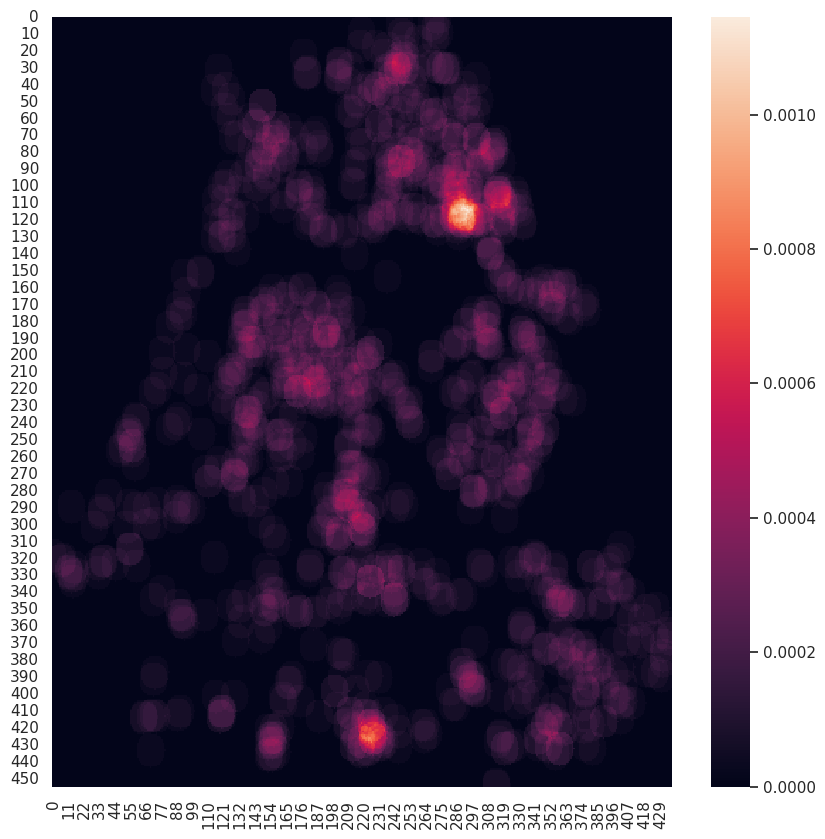

In [28]:
#Visualizacion de datos
sns.set(rc = {'figure.figsize':(10,10)})
p=sns.heatmap(matrizDensidad)

In [29]:
suma=0
for fila in matrizDensidad:
    for elemento in fila:
        suma += elemento

# Imprimir el resultado
print("La suma de todos los números en la matriz es:", suma)

La suma de todos los números en la matriz es: 12.612551775190575


# Implementación de colores

In [30]:
import colorsys

def rgb_a_hsv(r, g, b):
  (h, s, v) = colorsys.rgb_to_hsv(r, g, b)
  return (h, s, v)

def hsv_a_rgb(h, s, v):
  (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
  r = int(r)
  g = int(g)
  b = int(b)
  return (r, g, b)

In [31]:
from PIL import Image, ImageDraw

def pintar_color(r, g, b):
  img = Image.new('RGB', (300, 25))
  draw = ImageDraw.Draw(img)
  draw.rectangle([(0, 0), img.size], fill = (r,g,b))
  display(img)

In [32]:
n = 10


In [33]:
def gama_colores(color_ini, color_fin, n_colores):
  t_ini = rgb_a_hsv(color_ini[0], color_ini[1], color_ini[2])
  h_ini = t_ini[0]
  s_ini = t_ini[1]
  v_ini = t_ini[2]

  t_fin = rgb_a_hsv(color_fin[0], color_fin[1], color_fin[2])
  h_fin = t_fin[0]
  s_fin = t_fin[1]
  v_fin = t_fin[2]

  lista_colores = []
  for i in range(n_colores):
    h = h_ini + (i * (h_fin - h_ini) / (n - 1))
    s = s_ini + (i * (s_fin - s_ini) / (n - 1))
    v = v_ini + (i * (v_fin - v_ini) / (n - 1))
    t_rgb = hsv_a_rgb(h, s, v)
    lista_colores.append((t_rgb[0], t_rgb[1], t_rgb[2]))

  return lista_colores

In [34]:
lista_colores = gama_colores((255,255,0), (255,0,0), 10)
print(lista_colores)

[(255, 255, 0), (255, 226, 0), (255, 198, 0), (255, 170, 0), (255, 141, 0), (255, 113, 0), (255, 84, 0), (255, 56, 0), (255, 28, 0), (255, 0, 0)]


In [35]:
for i in range(len(lista_colores)):
  pintar_color(lista_colores[i][0], lista_colores[i][1], lista_colores[i][2])

In [36]:
# Crear una lista plana de la matriz excluyendo los valores iguales a 0
densidades_array = [valor for fila in matrizDensidad for valor in fila if valor != 0]

# Encontrar el valor más pequeño (diferente de 0) en la lista
d_min = min(densidades_array)

# Encontrar el valor más grande (diferente de 0) en la lista
d_max = max(densidades_array)

# Imprimir los resultados
print("Valor más pequeño:", d_min)
print("Valor más grande:", d_max)

Valor más pequeño: 3.183098861837907e-05
Valor más grande: 0.0011459155902616462


In [37]:
paso=(d_max-d_min)/n

In [38]:
lista_rangos=[]
for i in range(n):
  lista_rangos.append(d_min+(paso*i))

In [39]:
print(lista_rangos)
print(len(lista_rangos))

[3.183098861837907e-05, 0.0001432394487827058, 0.0002546479089470325, 0.00036605636911135923, 0.0004774648292756859, 0.0005888732894400126, 0.0007002817496043394, 0.0008116902097686661, 0.0009230986699329928, 0.0010345071300973195]
10


In [40]:
def asignar_color(valor, rangos, colores):
    # Verificar si el valor es menor al primer rango
    if valor < rangos[0]:
        return (255, 255, 255)  # Asignar el color blanco

    # Verificar en qué rango cae el valor
    for i, rango in enumerate(rangos):
        if valor >= rango and (i == len(rangos) - 1 or valor < rangos[i + 1]):
            return colores[i]

    # Si el valor es mayor o igual al último rango, asignar el color del último rango
    return colores[-1]

In [47]:
#Crear matriz de colores

def matrizColores(paleta, matrDens, rangos):
  matrColors=[]
  for fila in range(len(matrDens)):
    array=[]
    for columna in range(len(matrDens[0])):
      valor=matrDens[fila][columna]
      color_asignado=asignar_color(valor, rangos, paleta)
      array.append(color_asignado)
    matrColors.append(array)
  return matrColors




In [52]:
matrizColor=matrizColores(lista_colores,matrizDensidad, lista_rangos)
for fila in matrizColor:
    print(fila)

[(255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 25

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [70]:
from PIL import Image

# Tamaño de la imagen basado en las dimensiones de la matriz
ancho = len(matrizColor[0])  # Número de columnas
alto = len(matrizColor)     # Número de filas

# Crear una nueva imagen con fondo blanco y canal alfa
heatmap = Image.new("RGBA", (ancho, alto), (255, 255, 255, 0))

# Obtener un objeto de píxeles para la imagen
pixeles = heatmap.load()

# Aplicar los valores RGB de la matriz a la imagen
for y in range(alto):
    for x in range(ancho):
        # Obtener los valores RGB de la matriz
        r, g, b = matrizColor[y][x]

        # Ajustar el canal alfa según el color
        canal_alfa = 0 if (r, g, b) == (255, 255, 255) else 255

        # Asignar los valores RGB y el canal alfa a la imagen
        pixeles[x, y] = (r, g, b, canal_alfa)

# Guardar la imagen resultante
heatmap.save("heatmap.png")


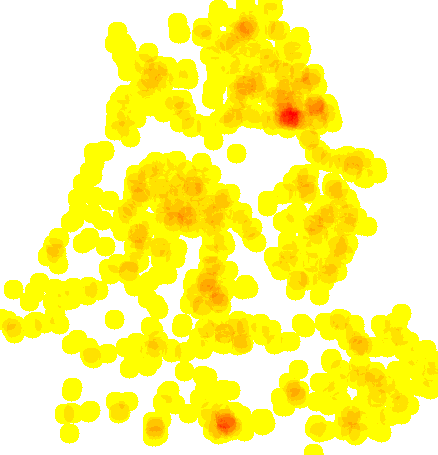

In [71]:
heatmap